In [1]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_3_no_xyz/area_3/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_3']
Processing conferenceRoom_1...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lounge_1...
Processing lounge_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing storage_1...
Processing storage_2...
Processing WC_1...
Processing WC_2...
success load!


In [2]:
print(point_sum_points[0].shape)

(1266990, 3)


In [2]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)



In [146]:
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from io import BytesIO
import cv2
import matplotlib.pyplot as plt

def generate_landmarks(s_start, s_end, top_view_map, obstacle_map):
        
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
    ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)

    # plt.imshow(ob_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    pil_img = Image.fromarray(top_view_map)
    draw = ImageDraw.Draw(pil_img)

    font_size = 25
    # Load a font (make sure you specify a valid .ttf font path on your system)
    font = ImageFont.load_default(font_size)

    # Number of circles to draw
    num_labels = 50

    # Circle radius
    r = 20

    # Image dimensions
    height, width, _ = top_view_map.shape

    i = 1
    valid_points = {}
    while i < num_labels: 
        # Generate random (x, y) within image boundaries
        x = random.randint(r, width - r)
        y = random.randint(r, height - r)
        
        if ob_map[y, x] == 1:
            continue
        
        # Check distance from all previously placed points
        too_close = False
        min_dist = 100
        for label_key, (px, py) in valid_points.items():
            if (y - px)**2 + (x - py)**2 < min_dist**2:
                too_close = True
                break
        
        # If this point is too close to an existing point, skip it
        if too_close:
            continue
        
        # Draw the circle
        draw.ellipse(
            [(x - r, y - r), (x + r, y + r)],
            fill="white",       # circle fill color
            outline="black",    # circle outline color
            width=2             # outline thickness
        )
        
        # Center the text inside the circle
        label = str(i)
        text_x = x - (font_size / 2)
        text_y = y - (font_size / 2)
        draw.text((text_x, text_y), label, fill="black", font=font)
        
        valid_points[str(i)] = (y, x)
        i += 1
        
        
    # mark start and end
    font_size = 30
    # Load a font (make sure you specify a valid .ttf font path on your system)
    font = ImageFont.load_default(font_size)
    x = s_start[1]
    y = s_start[0]
    # Draw the circle
    draw.ellipse(
        [(x - r, y - r), (x + r, y + r)],
        fill="white",       # circle fill color
        outline="red",    # circle outline color
        width=4             # outline thickness
    )

    # Center the text inside the circle
    label = 'S'
    text_x = x - (font_size / 3)
    text_y = y - (font_size / 1.5)
    draw.text((text_x, text_y), label, fill="red", font=font)
    valid_points[label] = (y, x)


    x = s_end[1]
    y = s_end[0]
    # Draw the circle
    draw.ellipse(
        [(x - r, y - r), (x + r, y + r)],
        fill="white",       # circle fill color
        outline="red",    # circle outline color
        width=4             # outline thickness
    )

    # Center the text inside the circle
    label = 'D'
    text_x = x - (font_size / 3)
    text_y = y - (font_size / 1.5)
    draw.text((text_x, text_y), label, fill="red", font=font)
    valid_points[label] = (y, x)

        
    pil_img.show()
    buffered = BytesIO()
    pil_img.save(buffered, format="JPEG")

    return buffered, valid_points
    
    


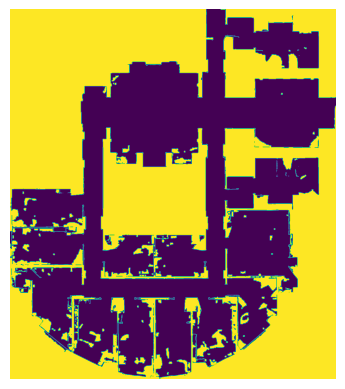

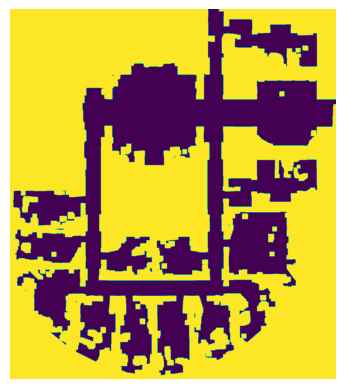

In [5]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [158]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO
import path_finding
import system_prompt
import chat_utils

importlib.reload(path_finding)

import os

filename = "3"


def get_all_candidate_maps(source_node, target_node):

    s_start = all_centers[source_node]
    s_end = all_centers[target_node]
    
    buffered, valid_points = generate_landmarks(s_start, s_end, top_view_map, obstacle_map)
    
    message = chat_utils.path_message_prepare(system_prompt.find_path_prompt, buffered)
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = response_message["paths"]
    
    all_topo_paths = []
    for k, v in ground_json.items():
        all_topo_paths.append(v)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        # map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [156]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # evaluation_map = Image.fromarray(evaluation_map)
    # evaluation_map.save(save_directory+f"metric.png")
    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    # plt.imshow(gaussian_modulation)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()
    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print(sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

gpt-4o response: 
{
    "observation": "By tracing the actual open hallways and doorways (avoiding all black areas), there appear to be four truly distinct ways to walk from S to D: one straight through the large central space (landmark 1), and three that skirt around it via the upper, middle, or lower corridors.",
    "paths": {
        "path_1": ["S", "1", "36", "D"],
        "path_2": ["S", "31", "18", "29", "23", "27", "36", "D"],
        "path_3": ["S", "31", "9", "16", "19", "22", "27", "36", "D"],
        "path_4": ["S", "5", "19", "22", "27", "36", "D"]
    }
}
['S', '1', '36', 'D']
['S', '31', '18', '29', '23', '27', '36', 'D']
['S', '31', '9', '16', '19', '22', '27', '36', 'D']
['S', '5', '19', '22', '27', '36', 'D']


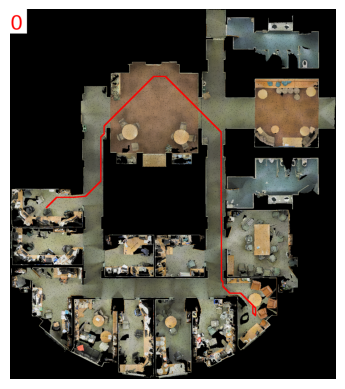

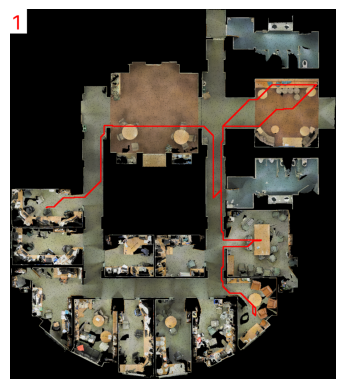

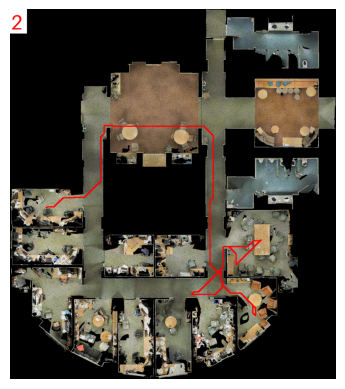

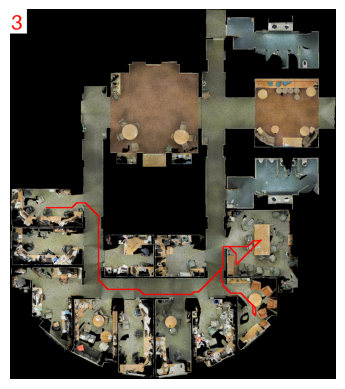

In [192]:
# test

import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)
importlib.reload(path_finding)
num_samples = 3
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]


s_start = all_centers[source_nodes[0]]
s_end = all_centers[target_nodes[0]]

buffered, valid_points = generate_landmarks(s_start, s_end, top_view_map, obstacle_map)

message = chat_utils.path_message_prepare(system_prompt.find_path_prompt, buffered)
response_message = chat_utils.chat_with_gpt4v(message)
ground_json = response_message["paths"]

all_topo_paths = []
for k, v in ground_json.items():
    all_topo_paths.append(v)
    
all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

candidate_map_list = []
for i, geo_path in enumerate(all_geo_paths):
    map_with_path = top_view_map.copy()
    x_indices, y_indices = zip(*geo_path)
    path_map = np.zeros(obstacle_map.shape)
    path_map[x_indices, y_indices] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
    path_map = cv2.dilate((path_map).astype('uint8'), kernel)
    map_with_path[path_map == 1] = [255, 0 , 0]
    
    map_with_path = path_finding.write_number(map_with_path, i)
    # map_with_path = path_finding.write_scene_name(map_with_path, valid_points)
    buffered = BytesIO()
    map_with_path.save(buffered, format="JPEG")
    candidate_map_list.append(buffered)

    # 使用 Matplotlib 显示图像
    # 使用 Matplotlib 显示图像.
    # map_with_path.save(save_directory+f"vis_{i}.png")
    plt.imshow(map_with_path)
    plt.axis('off')  # 隐藏坐标轴
    plt.show()
    


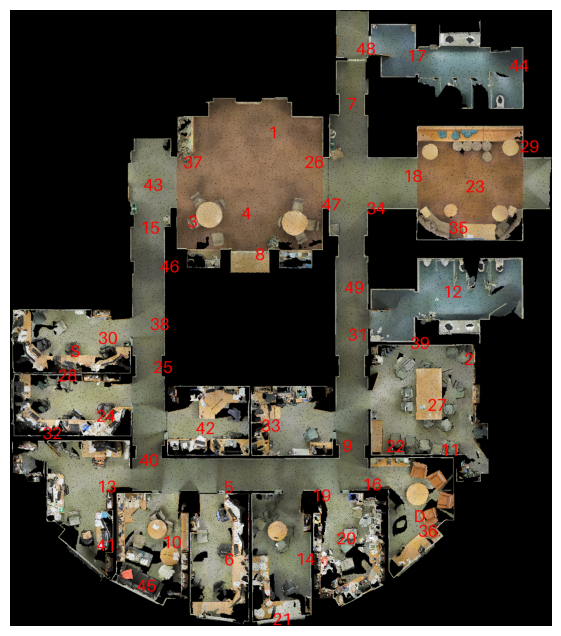

In [195]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

img = path_finding.write_scene_name(top_view_map, valid_points)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()

gpt-4o response: 
{
    "self_critique": "0",
    "paths": {
        "path_1": ["S", "1", "D"],
        "path_2": ["S", "9", "D"]
    }
}
0
['S', '1', 'D']
['S', '9', 'D']


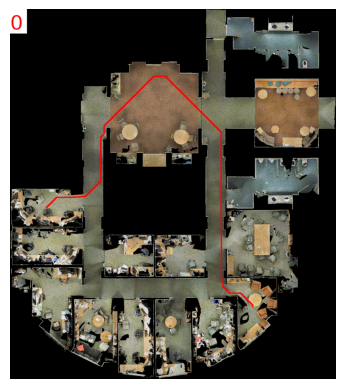

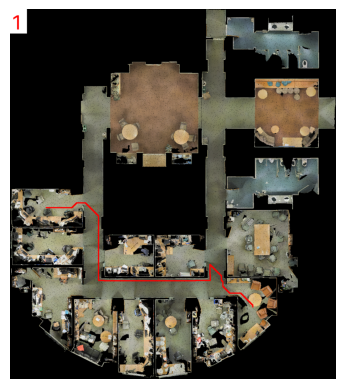

gpt-4o response: 
{
    "self_critique": "1"
}
1


In [194]:
importlib.reload(chat_utils)
importlib.reload(system_prompt)

critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

response_message = chat_utils.chat_with_gpt4v(message+critique_message)
ground_json = response_message["self_critique"]
print(ground_json)
while ground_json == "0":
    all_topo_paths = []
    for k, v in response_message["paths"].items():
        all_topo_paths.append(v)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph_for_large(all_topo_paths, obstacle_map, valid_points)

    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        # map_with_path = path_finding.write_scene_name(map_with_path, valid_points)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        # map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    critique_message = chat_utils.critique_message_prepare(system_prompt.self_critique_prompt, candidate_map_list)

    response_message = chat_utils.chat_with_gpt4v(message+critique_message)
    ground_json = response_message["self_critique"]
    print(ground_json)

gpt-4o response: 
{
    "observation": "From the starting point (S) to the destination (D), there is one clear, navigable path through the hallways and rooms.",
    "paths": {
        "path_1": ["S", "34", "48", "7", "18", "D"]
    }
}
['S', '34', '48', '7', '18', 'D']


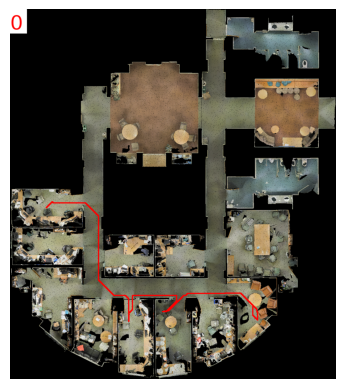

999.5525616878562
distance:  1489
gpt-4o response: 
{
    "observation": "The path marked with ID 0 travels extensively through multiple office areas with potential human presence and activity, which poses risks in terms of confidentiality and exposure.",
    "reason": "Given the scenario of transporting confidential files, the highest priority is to minimize exposure to areas with human activity. Path 0, while direct, goes through several office spaces filled with desks, which greatly increases the risk of accidental exposure of the classified document to unauthorized personnel. The objective is to select a pathway that avoids such high-risk areas to ensure the safety and privacy of the documents during transportation.",
    "self-critique": "Without additional pathway options displayed on the same map for comparative analysis, my assessment heavily depends on the visible route. However, the absence of alternative visible paths assumes that this is the only available choice if urgent 

KeyError: 13

In [172]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 3
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.infer_prompt, candidate_map_list, navigation_instruct)
            
    ground_json = chat_utils.chat_with_gpt4v(message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    # responses = []
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
    #     for future in concurrent.futures.as_completed(future_to_message):
    #         prompt = future_to_message[future]
    #         try:
    #             response = future.result()
    #             responses.append(response)
    #         except Exception as exc:
    #             print(f'{prompt} generated an exception: {exc}')

    # id_list = []
    # for i, response in enumerate(responses):
    #     ground_json = ast.literal_eval(response)
    #     id_list.append(int(ground_json["path_id"])) 
    # print(id_list)
            
    # counter = Counter(id_list)

    # index, count = counter.most_common(1)[0]
    print("select ", index)
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)
    
    